In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [4]:
df = pd.read_csv('../data/classification_model_data.csv', encoding='latin1')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139364 entries, 0 to 139363
Columns: 155 entries, female to economy_Zimbabwe
dtypes: bool(137), int64(18)
memory usage: 37.3 MB


In [5]:
bool_cols = df.select_dtypes(include=['bool']).columns
df[bool_cols] = df[bool_cols].astype(int)

In [6]:
df['worry_level'].value_counts()

worry_level
-1    58031
 1    48216
 0    33117
Name: count, dtype: int64

## Logistic Regression

In [7]:
X = df.drop(columns=['worry_level'])
y = df['worry_level']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
log_reg = LogisticRegression()

In [9]:
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

c:\Users\Mezzow Tecnologia\projects\financial-system_access\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [10]:
# avaliando o modelo
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

          -1       0.60      0.74      0.67     11646
           0       0.33      0.01      0.02      6593
           1       0.53      0.73      0.61      9634

    accuracy                           0.57     27873
   macro avg       0.49      0.49      0.43     27873
weighted avg       0.51      0.57      0.49     27873

Confusion Matrix:
[[8648   49 2949]
 [3164   54 3375]
 [2523   63 7048]]
Accuracy Score:
0.5650629641588634


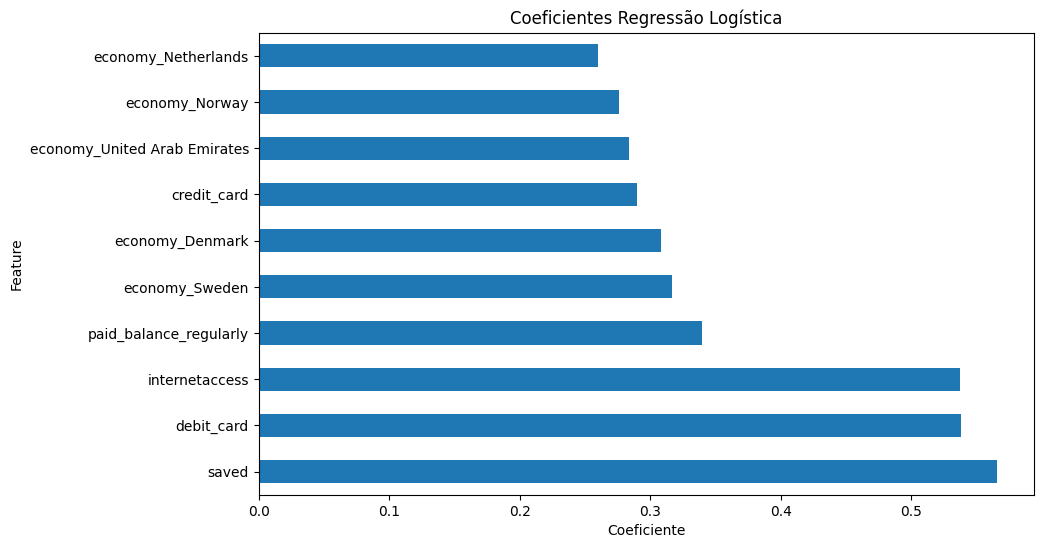

In [11]:
# visualizando coeficientes
coef = log_reg.coef_[0]
features = X.columns

coef_df = pd.DataFrame({'Feature': features, 'Coefficient': coef})
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

coef_df.head(10).plot(kind='barh', x='Feature', y='Coefficient', legend=False, figsize=(10, 6))
plt.title('Coeficientes Regressão Logística')
plt.xlabel('Coeficiente')
plt.ylabel('Feature')
plt.show()

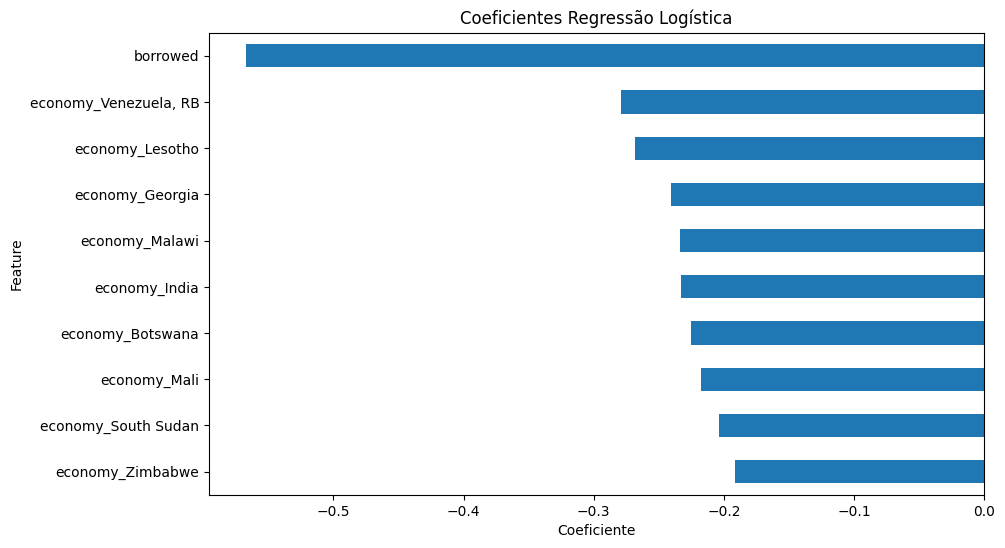

In [12]:
coef_df.tail(10).plot(kind='barh', x='Feature', y='Coefficient', legend=False, figsize=(10, 6))
plt.title('Coeficientes Regressão Logística')
plt.xlabel('Coeficiente')
plt.show()

In [13]:
import pickle

model_dir = '../models'
os.makedirs(model_dir, exist_ok=True) # Create directory if it doesn't exist
log_reg_pkl_path = os.path.join(model_dir, 'basic_logistic_regression.pkl')

try:
    with open(log_reg_pkl_path, 'wb') as f:
        pickle.dump(log_reg, f)
    print(f"Modelo Logistic Regression básico salvo em: {log_reg_pkl_path}")
except Exception as e:
    print(f"Erro ao salvar modelo Logistic Regression básico: {e}")

Modelo Logistic Regression básico salvo em: ../models\basic_logistic_regression.pkl


In [19]:
# modelo sem paises
df_no_countries = df.loc[:, ~df.columns.str.startswith('economy_')]

In [20]:
X = df_no_countries.drop(columns=['worry_level'])
y = df_no_countries['worry_level']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Definir o espaço de busca de hiperparâmetros para Regressão Logística
log_reg_search_space = {
    'C': Real(1e-4, 1e+2, prior='log-uniform'), # Força de regularização (escala log)
    'penalty': Categorical(['l2']),            # Apenas L2 com solvers comuns
    'solver': Categorical(['liblinear', 'lbfgs']), # Solvers que suportam L2
    'class_weight': Categorical([None, 'balanced']) # Considerar balanceamento de classes
}

In [22]:
log_reg_bayes_search = BayesSearchCV(
    estimator=LogisticRegression(max_iter=2000, random_state=42), # Aumentar max_iter pode ajudar na convergência
    search_spaces=log_reg_search_space,
    n_iter=16,  # Número de iterações da busca Bayesiana (ajuste conforme necessário)
    cv=5,       # 5-fold cross-validation
    scoring='accuracy', # Métrica de avaliação
    n_jobs=-1,  # Usar todos os cores da CPU
    random_state=42,
    verbose=1   # Mostrar progresso
)

In [23]:
# Treinar a busca Bayesiana
print("Iniciando BayesSearchCV para Logistic Regression...")
log_reg_bayes_search.fit(X_train, y_train)

# Exibir os melhores parâmetros
print("\nMelhores parâmetros para Logistic Regression (Busca Bayesiana):")
print(log_reg_bayes_search.best_params_)

Iniciando BayesSearchCV para Logistic Regression...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Mel

In [24]:
best_log_reg_bayes = log_reg_bayes_search.best_estimator_

# Fazer previsões com o melhor modelo
y_pred_log_reg_bayes = best_log_reg_bayes.predict(X_test)

In [25]:
print("\nLogistic Regression (Otimizado com BayesSearch) Classification Report:")
print(classification_report(y_test, y_pred_log_reg_bayes))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_log_reg_bayes))
print("Accuracy Score:")
print(accuracy_score(y_test, y_pred_log_reg_bayes))


Logistic Regression (Otimizado com BayesSearch) Classification Report:
              precision    recall  f1-score   support

          -1       0.58      0.74      0.65     11646
           0       0.50      0.00      0.00      6593
           1       0.51      0.70      0.59      9634

    accuracy                           0.55     27873
   macro avg       0.53      0.48      0.41     27873
weighted avg       0.54      0.55      0.48     27873

Confusion Matrix:
[[8639    1 3006]
 [3287    1 3305]
 [2936    0 6698]]
Accuracy Score:
0.5502816345567395


C:\Users\Mezzow Tecnologia\AppData\Local\Temp\ipykernel_25364\757486665.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coef_df_bayes.head(20), palette='viridis') # Top 20 por magnitude


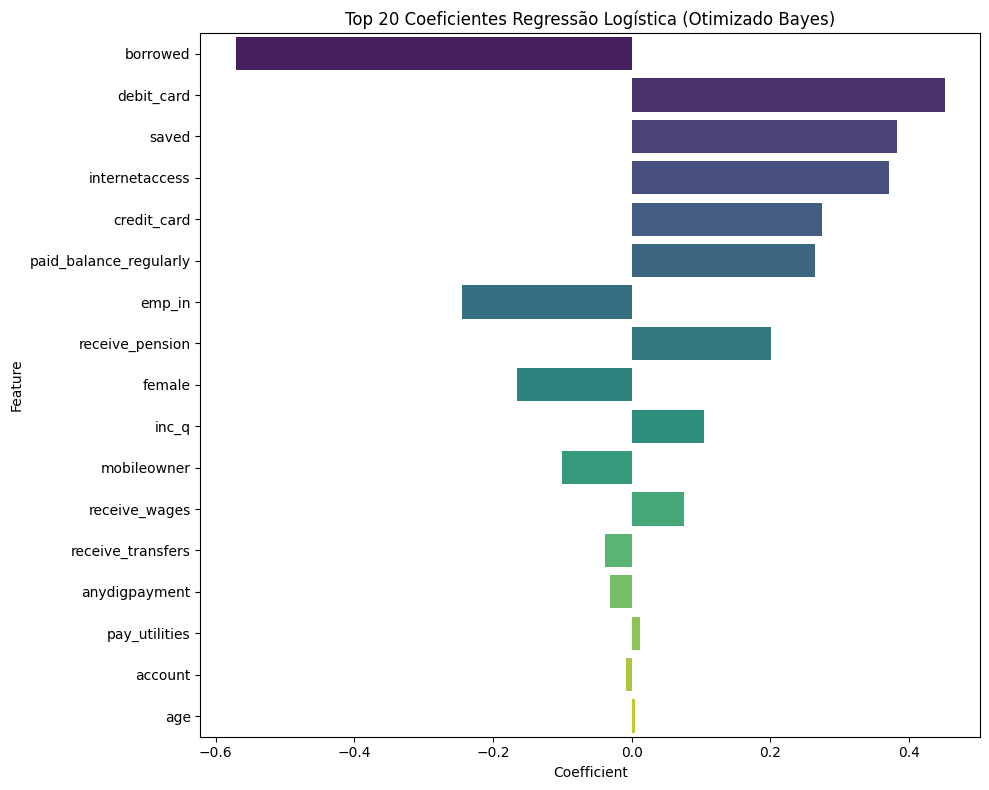

In [26]:
try:
    # Verificar se o solver permite coef_ (nem todos os pipelines retornam diretamente)
    if hasattr(best_log_reg_bayes, 'coef_'):
        coef_bayes = best_log_reg_bayes.coef_[0]
        features_bayes = X.columns
        coef_df_bayes = pd.DataFrame({'Feature': features_bayes, 'Coefficient': coef_bayes})
        coef_df_bayes = coef_df_bayes.sort_values(by='Coefficient', key=abs, ascending=False) # Ordenar por valor absoluto

        plt.figure(figsize=(10, 8))
        sns.barplot(x='Coefficient', y='Feature', data=coef_df_bayes.head(20), palette='viridis') # Top 20 por magnitude
        plt.title('Top 20 Coeficientes Regressão Logística (Otimizado Bayes)')
        plt.tight_layout()
        plt.show()
    else:
        print("Não foi possível extrair coeficientes diretamente do melhor estimador.")
except Exception as e:
    print(f"Erro ao plotar coeficientes: {e}")

## Random Forrest

In [7]:
rf = RandomForestClassifier()

rf.fit(X_train, y_train)

RandomForestClassifier()

In [8]:
rf_predictions = rf.predict(X_test)

In [9]:
print('Random Forest Model Performance:')

print('Classification Report:')

print(classification_report(y_test, rf_predictions))

Random Forest Model Performance:
Classification Report:
              precision    recall  f1-score   support

          -1       0.63      0.70      0.67     11646
           0       0.32      0.19      0.24      6593
           1       0.57      0.66      0.61      9634

    accuracy                           0.56     27873
   macro avg       0.51      0.51      0.50     27873
weighted avg       0.54      0.56      0.54     27873



## Neural Network

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from tqdm import tqdm

In [12]:
# Converter rótulos ordinais para rótulos binários cumulativos para regressão ordinal.
# Aqui, assumimos que os valores de worry_level estão em {-1, 0, 1}. Primeiro, mapeamos para {0, 1, 2} adicionando 1.
# Em seguida, o vetor binário para cada instância é:
#   binary[j] = 1 se (y+1) > j, senão 0, para j em range(num_thresholds)
def convert_to_binary(y):
    # y: tensor de rótulos ordinais (por exemplo, -1,0,1)
    new_y = y + 1
    batch_size = new_y.shape[0]
    num_thresholds = 2
    binary = torch.zeros((batch_size, num_thresholds))
    for j in range(num_thresholds):
        binary[:, j] = (new_y > j).float()
    return binary

# Criar uma divisão de validação a partir de X_train e y_train (80% treino / 20% validação)
X_train_nn, X_val, y_train_nn, y_val = train_test_split(X_train, y_train,
                                                          test_size=0.2,
                                                          random_state=42,
                                                          stratify=y_train)

In [13]:
# Converter DataFrames/Series do pandas para tensores torch.
X_train_tensor = torch.tensor(X_train_nn.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_nn.values, dtype=torch.int64)
y_train_binary = convert_to_binary(y_train_tensor)

X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.int64)
y_val_binary = convert_to_binary(y_val_tensor)

# Criar TensorDatasets e DataLoaders.
from torch.utils.data import TensorDataset, DataLoader
batch_size = 64

train_dataset = TensorDataset(X_train_tensor, y_train_binary)
val_dataset = TensorDataset(X_val_tensor, y_val_binary)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [16]:
# Definir uma rede neural simples para regressão ordinal.
class OrdinalRegressionNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_thresholds):
        super(OrdinalRegressionNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_thresholds)  # saídas logits para cada limiar

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        logits = self.fc2(out)
        return logits

input_dim = X_train_tensor.shape[1]
hidden_dim = 64
num_thresholds = 2  # Para 3 classes ordinais

model = OrdinalRegressionNN(input_dim, hidden_dim, num_thresholds)

In [17]:
# Definir a função de perda e o otimizador.
# Usamos BCEWithLogitsLoss porque nossa rede produz logits para cada decisão binária.
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Loop de treinamento com tqdm para rastreamento de progresso e coleta de perdas de treino e validação.
num_epochs = 20
train_loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_batches = 0
    for batch_x, batch_y in tqdm(train_loader, desc=f"Época de Treino {epoch+1}"):
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        train_batches += 1
    avg_train_loss = running_loss / train_batches
    train_loss_history.append(avg_train_loss)
    
    # Avaliar no conjunto de validação
    model.eval()
    val_running_loss = 0.0
    val_batches = 0
    with torch.no_grad():
        for val_x, val_y in tqdm(val_loader, desc=f"Época de Validação {epoch+1}"):
            val_outputs = model(val_x)
            val_loss = criterion(val_outputs, val_y)
            val_running_loss += val_loss.item()
            val_batches += 1
    avg_val_loss = val_running_loss / val_batches
    val_loss_history.append(avg_val_loss)
    
    print(f"Época {epoch+1}/{num_epochs}, Perda de Treino: {avg_train_loss:.4f}, Perda de Validação: {avg_val_loss:.4f}")

Época de Validação 1: 100%|██████████| 349/349 [00:00<00:00, 983.29it/s]


Época 1/20, Perda de Treino: 0.5416, Perda de Validação: 0.5087


Época de Validação 2: 100%|██████████| 349/349 [00:00<00:00, 1373.64it/s]


Época 2/20, Perda de Treino: 0.5118, Perda de Validação: 0.5061


Época de Validação 3: 100%|██████████| 349/349 [00:00<00:00, 1383.40it/s]


Época 3/20, Perda de Treino: 0.5090, Perda de Validação: 0.5097


Época de Validação 4: 100%|██████████| 349/349 [00:00<00:00, 918.96it/s] 


Época 4/20, Perda de Treino: 0.5067, Perda de Validação: 0.5150


Época de Validação 5: 100%|██████████| 349/349 [00:00<00:00, 1419.97it/s]


Época 5/20, Perda de Treino: 0.5055, Perda de Validação: 0.5009


Época de Validação 6: 100%|██████████| 349/349 [00:00<00:00, 1358.83it/s]


Época 6/20, Perda de Treino: 0.5037, Perda de Validação: 0.5043


Época de Validação 7: 100%|██████████| 349/349 [00:00<00:00, 902.93it/s] 


Época 7/20, Perda de Treino: 0.5032, Perda de Validação: 0.4995


Época de Validação 8: 100%|██████████| 349/349 [00:00<00:00, 1362.31it/s]


Época 8/20, Perda de Treino: 0.5020, Perda de Validação: 0.4987


Época de Validação 9: 100%|██████████| 349/349 [00:00<00:00, 1322.12it/s]


Época 9/20, Perda de Treino: 0.5016, Perda de Validação: 0.4997


Época de Validação 10: 100%|██████████| 349/349 [00:00<00:00, 1362.98it/s]


Época 10/20, Perda de Treino: 0.5007, Perda de Validação: 0.4983


Época de Validação 11: 100%|██████████| 349/349 [00:00<00:00, 1322.05it/s]


Época 11/20, Perda de Treino: 0.4993, Perda de Validação: 0.4991


Época de Validação 12: 100%|██████████| 349/349 [00:00<00:00, 1338.39it/s]


Época 12/20, Perda de Treino: 0.4990, Perda de Validação: 0.4983


Época de Validação 13: 100%|██████████| 349/349 [00:00<00:00, 1461.69it/s]


Época 13/20, Perda de Treino: 0.4983, Perda de Validação: 0.4987


Época de Validação 14: 100%|██████████| 349/349 [00:00<00:00, 1282.84it/s]


Época 14/20, Perda de Treino: 0.4975, Perda de Validação: 0.4998


Época de Validação 15: 100%|██████████| 349/349 [00:00<00:00, 1416.79it/s]


Época 15/20, Perda de Treino: 0.4975, Perda de Validação: 0.5006


Época de Validação 16: 100%|██████████| 349/349 [00:00<00:00, 1348.80it/s]


Época 16/20, Perda de Treino: 0.4961, Perda de Validação: 0.4960


Época de Validação 17: 100%|██████████| 349/349 [00:00<00:00, 1472.33it/s]


Época 17/20, Perda de Treino: 0.4958, Perda de Validação: 0.4968


Época de Validação 18: 100%|██████████| 349/349 [00:00<00:00, 1215.21it/s]


Época 18/20, Perda de Treino: 0.4948, Perda de Validação: 0.4969


Época de Validação 19: 100%|██████████| 349/349 [00:00<00:00, 1434.23it/s]


Época 19/20, Perda de Treino: 0.4947, Perda de Validação: 0.4961


Época de Validação 20: 100%|██████████| 349/349 [00:00<00:00, 1372.57it/s]

Época 20/20, Perda de Treino: 0.4943, Perda de Validação: 0.4970


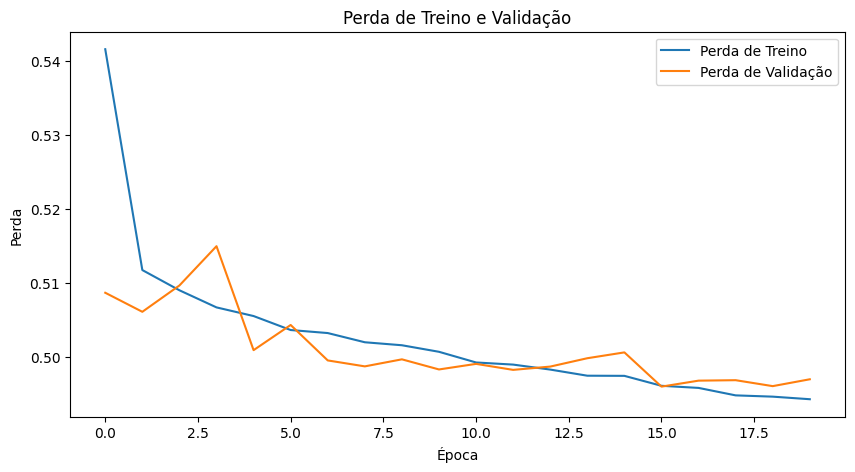

In [18]:
# Plotar as perdas de treino e validação.
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Perda de Treino')
plt.plot(val_loss_history, label='Perda de Validação')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.title('Perda de Treino e Validação')
plt.legend()
plt.show()

In [20]:
# Avaliar o modelo no conjunto de teste.
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.int64)
y_test_binary = convert_to_binary(y_test_tensor)

model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_binary).item()
    test_probabilities = torch.sigmoid(test_outputs)  # Obter probabilidades
    test_predictions_binary = (test_probabilities > 0.5).float()  # Previsões binárias

    # Converter previsões binárias para rótulos ordinais
    test_predictions_ordinal = test_predictions_binary.sum(dim=1).long()  # Soma das previsões binárias

    # Converter rótulos binários verdadeiros para rótulos ordinais
    y_test_ordinal = y_test_binary.sum(dim=1).long()  # Soma dos rótulos binários verdadeiros

    # Calcular métricas
    test_accuracy = accuracy_score(y_test_ordinal.numpy(), test_predictions_ordinal.numpy())
    test_confusion = confusion_matrix(y_test_ordinal.numpy(), test_predictions_ordinal.numpy())
    test_classification_report = classification_report(y_test_ordinal.numpy(), test_predictions_ordinal.numpy())

    # Imprimir resultados
    print(f"Perda de Teste: {test_loss:.4f}")
    print(f"Acurácia de Teste: {test_accuracy:.4f}")
    print("Matriz de Confusão:\n", test_confusion)
    print("Relatório de Classificação:\n", test_classification_report)


Perda de Teste: 0.5016
Acurácia de Teste: 0.5607
Matriz de Confusão:
 [[7612 3232  802]
 [1965 3120 1508]
 [ 924 3813 4897]]
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.72      0.65      0.69     11646
           1       0.31      0.47      0.37      6593
           2       0.68      0.51      0.58      9634

    accuracy                           0.56     27873
   macro avg       0.57      0.55      0.55     27873
weighted avg       0.61      0.56      0.58     27873



In [30]:
scaler = StandardScaler()

# Ajustar o scaler APENAS nos dados de treino (X_train)
# Usaremos X_train e X_test definidos anteriormente (sem as colunas 'economy_')
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # Usar o mesmo scaler ajustado

# Agora, criaremos as divisões treino/validação a partir dos dados escalados
X_train_nn_scaled, X_val_scaled, y_train_nn, y_val = train_test_split(
    X_train_scaled, y_train, # Usar X_train_scaled aqui
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

In [32]:
def convert_to_binary(y):
    # y: tensor de rótulos ordinais (por exemplo, -1,0,1)
    # Mapeia y de {-1, 0, 1} para {0, 1, 2}
    new_y = y + 1
    batch_size = y.shape[0] # Usar y diretamente para batch_size
    num_thresholds = 2 # Para 3 classes (k-1 limiares)
    binary = torch.zeros((batch_size, num_thresholds), dtype=torch.float32) # Especificar dtype
    for j in range(num_thresholds):
        binary[:, j] = (new_y > j).float()
    return binary

In [33]:
X_train_tensor = torch.tensor(X_train_nn_scaled, dtype=torch.float32) # Alterado
y_train_tensor = torch.tensor(y_train_nn.values, dtype=torch.int64)
y_train_binary = convert_to_binary(y_train_tensor)

X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32) # Alterado
y_val_tensor = torch.tensor(y_val.values, dtype=torch.int64)
y_val_binary = convert_to_binary(y_val_tensor)

# Criar TensorDatasets e DataLoaders.
from torch.utils.data import TensorDataset, DataLoader
batch_size = 128 # Pode experimentar aumentar o batch size

train_dataset = TensorDataset(X_train_tensor, y_train_binary)
val_dataset = TensorDataset(X_val_tensor, y_val_binary)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [34]:
class PowerfulOrdinalNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, num_thresholds, dropout_rate=0.3):
        super(PowerfulOrdinalNN, self).__init__()
        # Camada 1: Linear -> BatchNorm -> ReLU -> Dropout
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.bn1 = nn.BatchNorm1d(hidden_dim1) # Batch Normalization
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate) # Dropout

        # Camada 2: Linear -> BatchNorm -> ReLU -> Dropout
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)

        # Camada de Saída
        self.fc3 = nn.Linear(hidden_dim2, num_thresholds) # Saída de logits para cada limiar

    def forward(self, x):
        # Passagem pela Camada 1
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.dropout1(out)

        # Passagem pela Camada 2
        out = self.fc2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.dropout2(out)

        # Passagem pela Camada de Saída
        logits = self.fc3(out)
        return logits

# --- Instanciar a Nova Rede ---
input_dim = X_train_tensor.shape[1]
hidden_dim1 = 128 # Mais neurônios na primeira camada oculta
hidden_dim2 = 64  # Segunda camada oculta
num_thresholds = 2  # Para 3 classes ordinais
dropout_rate = 0.4 # Taxa de dropout (pode ajustar entre 0.2 e 0.5)

model = PowerfulOrdinalNN(input_dim, hidden_dim1, hidden_dim2, num_thresholds, dropout_rate)

print("Estrutura do Modelo:")
print(model)

Estrutura do Modelo:
PowerfulOrdinalNN(
  (fc1): Linear(in_features=154, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.4, inplace=False)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)


In [36]:
# Definir a função de perda e o otimizador
criterion = nn.BCEWithLogitsLoss() # Mantém BCEWithLogitsLoss para a abordagem ordinal
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5) # AdamW com weight decay (regularização L2)

# Learning Rate Scheduler: Reduz LR se a perda de validação não melhorar
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

In [37]:
# Early Stopping Parameters
early_stopping_patience = 10 # Número de épocas para esperar por melhoria antes de parar
best_val_loss = float('inf')
epochs_no_improve = 0

model_save_path = '../models/best_ordinal_nn_model.pth' # Caminho para salvar o melhor modelo (opcional)

# Loop de treinamento
num_epochs = 50 # Aumentar o número de épocas, pois temos Early Stopping
train_loss_history = []
val_loss_history = []

print("\nIniciando Treinamento da Rede Neural Aprimorada...")

for epoch in range(num_epochs):
    model.train() # Modo de treinamento (ativa Dropout e BatchNorm)
    running_loss = 0.0
    train_batches = 0
    # Barra de progresso para treino
    train_pbar = tqdm(train_loader, desc=f"Época Treino {epoch+1}/{num_epochs}", leave=False)
    for batch_x, batch_y in train_pbar:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        train_batches += 1
        train_pbar.set_postfix({'loss': running_loss / train_batches}) # Atualiza a barra com a perda média

    avg_train_loss = running_loss / train_batches
    train_loss_history.append(avg_train_loss)

    # Avaliação no conjunto de validação
    model.eval() # Modo de avaliação (desativa Dropout e usa estatísticas de BatchNorm)
    val_running_loss = 0.0
    val_batches = 0
    # Barra de progresso para validação
    val_pbar = tqdm(val_loader, desc=f"Época Validação {epoch+1}/{num_epochs}", leave=False)
    with torch.no_grad():
        for val_x, val_y in val_pbar:
            val_outputs = model(val_x)
            val_loss = criterion(val_outputs, val_y)
            val_running_loss += val_loss.item()
            val_batches += 1
            val_pbar.set_postfix({'val_loss': val_running_loss / val_batches})

    avg_val_loss = val_running_loss / val_batches
    val_loss_history.append(avg_val_loss)

    current_lr = optimizer.param_groups[0]['lr'] # Pega o LR atual
    print(f"Época {epoch+1}/{num_epochs}, Perda Treino: {avg_train_loss:.4f}, Perda Validação: {avg_val_loss:.4f}, LR: {current_lr:.6f}")

    # Atualizar o scheduler com a perda de validação
    scheduler.step(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        # --- Salvar o state_dict do modelo ---
        torch.save(model.state_dict(), model_save_path)
        print(f"  -> Melhoria na validação, salvando modelo (perda: {best_val_loss:.4f})")
    else:
        epochs_no_improve += 1
        print(f"  -> Sem melhoria na validação por {epochs_no_improve} épocas.")

    if epochs_no_improve >= early_stopping_patience:
        print(f"\nParando cedo na época {epoch+1} pois a perda de validação não melhorou por {early_stopping_patience} épocas.")
        break # Interrompe o loop

print(f"\nCarregando o melhor modelo salvo de {model_save_path} (com perda de validação: {best_val_loss:.4f})")
model.load_state_dict(torch.load(model_save_path))

print("\nTreinamento concluído.")


Iniciando Treinamento da Rede Neural Aprimorada...


Época 1/50, Perda Treino: 0.5331, Perda Validação: 0.5040, LR: 0.001000
  -> Melhoria na validação, salvando modelo (perda: 0.5040)


Época 2/50, Perda Treino: 0.5135, Perda Validação: 0.4998, LR: 0.001000
  -> Melhoria na validação, salvando modelo (perda: 0.4998)


Época 3/50, Perda Treino: 0.5096, Perda Validação: 0.4989, LR: 0.001000
  -> Melhoria na validação, salvando modelo (perda: 0.4989)


Época 4/50, Perda Treino: 0.5073, Perda Validação: 0.4974, LR: 0.001000
  -> Melhoria na validação, salvando modelo (perda: 0.4974)


Época 5/50, Perda Treino: 0.5058, Perda Validação: 0.4959, LR: 0.001000
  -> Melhoria na validação, salvando modelo (perda: 0.4959)


Época 6/50, Perda Treino: 0.5043, Perda Validação: 0.4959, LR: 0.001000
  -> Sem melhoria na validação por 1 épocas.


Época 7/50, Perda Treino: 0.5029, Perda Validação: 0.4956, LR: 0.001000
  -> Melhoria na validação, salvando modelo (perda: 0.4956)


Época 8/50, Perda Treino: 0.5024, Perda Validação: 0.4949, LR: 0.001000
  -> Melhoria na validação, salvando modelo (perda: 0.4949)


Época 9/50, Perda Treino: 0.5013, Perda Validação: 0.4947, LR: 0.001000
  -> Melhoria na validação, salvando modelo (perda: 0.4947)


Época 10/50, Perda Treino: 0.5002, Perda Validação: 0.4948, LR: 0.001000
  -> Sem melhoria na validação por 1 épocas.


Época 11/50, Perda Treino: 0.4993, Perda Validação: 0.4942, LR: 0.001000
  -> Melhoria na validação, salvando modelo (perda: 0.4942)


Época 12/50, Perda Treino: 0.4990, Perda Validação: 0.4936, LR: 0.001000
  -> Melhoria na validação, salvando modelo (perda: 0.4936)


Época 13/50, Perda Treino: 0.4982, Perda Validação: 0.4928, LR: 0.001000
  -> Melhoria na validação, salvando modelo (perda: 0.4928)


Época 14/50, Perda Treino: 0.4981, Perda Validação: 0.4935, LR: 0.001000
  -> Sem melhoria na validação por 1 épocas.


Época 15/50, Perda Treino: 0.4977, Perda Validação: 0.4936, LR: 0.001000
  -> Sem melhoria na validação por 2 épocas.


Época 16/50, Perda Treino: 0.4964, Perda Validação: 0.4930, LR: 0.001000
  -> Sem melhoria na validação por 3 épocas.


Época 17/50, Perda Treino: 0.4963, Perda Validação: 0.4930, LR: 0.001000
  -> Sem melhoria na validação por 4 épocas.


Época 18/50, Perda Treino: 0.4955, Perda Validação: 0.4926, LR: 0.001000
  -> Melhoria na validação, salvando modelo (perda: 0.4926)


Época 19/50, Perda Treino: 0.4951, Perda Validação: 0.4928, LR: 0.001000
  -> Sem melhoria na validação por 1 épocas.


Época 20/50, Perda Treino: 0.4941, Perda Validação: 0.4927, LR: 0.001000
  -> Sem melhoria na validação por 2 épocas.


Época 21/50, Perda Treino: 0.4941, Perda Validação: 0.4936, LR: 0.001000
  -> Sem melhoria na validação por 3 épocas.


Época 22/50, Perda Treino: 0.4947, Perda Validação: 0.4931, LR: 0.001000
  -> Sem melhoria na validação por 4 épocas.


Época 23/50, Perda Treino: 0.4927, Perda Validação: 0.4929, LR: 0.001000
  -> Sem melhoria na validação por 5 épocas.


Época 24/50, Perda Treino: 0.4925, Perda Validação: 0.4923, LR: 0.001000
  -> Melhoria na validação, salvando modelo (perda: 0.4923)


Época 25/50, Perda Treino: 0.4932, Perda Validação: 0.4923, LR: 0.001000
  -> Sem melhoria na validação por 1 épocas.


Época 26/50, Perda Treino: 0.4920, Perda Validação: 0.4924, LR: 0.001000
  -> Sem melhoria na validação por 2 épocas.


Época 27/50, Perda Treino: 0.4924, Perda Validação: 0.4927, LR: 0.001000
  -> Sem melhoria na validação por 3 épocas.


Época 28/50, Perda Treino: 0.4912, Perda Validação: 0.4930, LR: 0.001000
  -> Sem melhoria na validação por 4 épocas.


Época 29/50, Perda Treino: 0.4921, Perda Validação: 0.4933, LR: 0.001000
  -> Sem melhoria na validação por 5 épocas.


Época 30/50, Perda Treino: 0.4908, Perda Validação: 0.4935, LR: 0.001000
  -> Sem melhoria na validação por 6 épocas.


Época 31/50, Perda Treino: 0.4878, Perda Validação: 0.4929, LR: 0.000100
  -> Sem melhoria na validação por 7 épocas.


Época 32/50, Perda Treino: 0.4868, Perda Validação: 0.4928, LR: 0.000100
  -> Sem melhoria na validação por 8 épocas.


Época 33/50, Perda Treino: 0.4873, Perda Validação: 0.4926, LR: 0.000100
  -> Sem melhoria na validação por 9 épocas.


Época 34/50, Perda Treino: 0.4868, Perda Validação: 0.4926, LR: 0.000100
  -> Sem melhoria na validação por 10 épocas.

Parando cedo na época 34 pois a perda de validação não melhorou por 10 épocas.

Carregando o melhor modelo salvo de ../models/best_ordinal_nn_model.pth (com perda de validação: 0.4923)

Treinamento concluído.


In [53]:
print(f"\nCarregando o melhor modelo salvo de {model_save_path} (com perda de validação: {best_val_loss:.4f})")
model.load_state_dict(torch.load(model_save_path)) # Use 'model' and 'model_save_path'

# --- Save the state_dict using pickle as well ---
import pickle
pkl_save_path_ordinal = '../models/best_ordinal_nn_model.pkl' # Define the .pkl file path for the ordinal model
try:
    with open(pkl_save_path_ordinal, 'wb') as f:
        pickle.dump(model, f)
except Exception as e:
    print(f"Erro ao salvar state_dict ordinal como pickle: {e}")
# --- End of pickle saving ---


print("\nTreinamento concluído.")


Carregando o melhor modelo salvo de ../models/best_ordinal_nn_model.pth (com perda de validação: 0.4923)

Treinamento concluído.


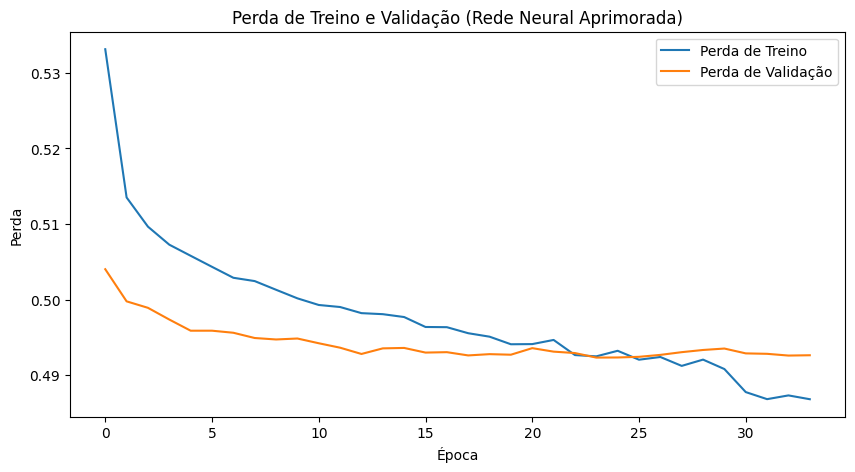

In [38]:
# plotar as perdas de treino e validação
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Perda de Treino')
plt.plot(val_loss_history, label='Perda de Validação')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.title('Perda de Treino e Validação (Rede Neural Aprimorada)')
plt.legend()
plt.show()

In [40]:
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32) # Alterado
y_test_tensor = torch.tensor(y_test.values, dtype=torch.int64)
y_test_binary = convert_to_binary(y_test_tensor)

test_dataset = TensorDataset(X_test_tensor, y_test_binary)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
all_predictions_ordinal = []
all_true_ordinal = y_test.tolist()
total_test_loss = 0.0
test_batches = 0

print("\n--- Iniciando Avaliação no Conjunto de Teste (em Batches) ---")

with torch.no_grad():
    test_pbar = tqdm(test_loader, desc="Avaliando Teste", leave=False)
    for batch_x, batch_y_binary in test_pbar:
        # Fazer previsões
        test_outputs = model(batch_x)

        # Calcular perda do batch (opcional, mas útil)
        batch_loss = criterion(test_outputs, batch_y_binary)
        total_test_loss += batch_loss.item()
        test_batches += 1

        # Converter outputs para previsões ordinais
        test_probabilities = torch.sigmoid(test_outputs)
        test_predictions_binary = (test_probabilities > 0.5).float()
        batch_predictions_ordinal = test_predictions_binary.sum(dim=1).long() - 1 # Mapear para -1, 0, 1

        # Coletar previsões do batch
        all_predictions_ordinal.extend(batch_predictions_ordinal.numpy())

        test_pbar.set_postfix({'batch_loss': batch_loss.item()})

# Calcular a perda média no teste
avg_test_loss = total_test_loss / test_batches

# Calcular métricas finais usando as listas coletadas
test_accuracy = accuracy_score(all_true_ordinal, all_predictions_ordinal)
test_confusion = confusion_matrix(all_true_ordinal, all_predictions_ordinal)
target_names = ['Low Worry (-1)', 'Medium Worry (0)', 'High Worry (1)']
test_classification_report = classification_report(all_true_ordinal, all_predictions_ordinal, target_names=target_names)

# Imprimir resultados
print(f"\n--- Avaliação Final no Conjunto de Teste ---")
print(f"Perda Média de Teste: {avg_test_loss:.4f}")
print(f"Acurácia de Teste: {test_accuracy:.4f}")
print("Matriz de Confusão:\n", test_confusion)
print("Relatório de Classificação:\n", test_classification_report)


--- Iniciando Avaliação no Conjunto de Teste (em Batches) ---


Avaliando Teste:   0%|          | 0/218 [00:00<?, ?it/s]


--- Avaliação Final no Conjunto de Teste ---
Perda Média de Teste: 0.4982
Acurácia de Teste: 0.5641
Matriz de Confusão:
 [[7411 3303  932]
 [1832 3038 1723]
 [ 827 3533 5274]]
Relatório de Classificação:
                   precision    recall  f1-score   support

  Low Worry (-1)       0.74      0.64      0.68     11646
Medium Worry (0)       0.31      0.46      0.37      6593
  High Worry (1)       0.67      0.55      0.60      9634

        accuracy                           0.56     27873
       macro avg       0.57      0.55      0.55     27873
    weighted avg       0.61      0.56      0.58     27873



In [41]:
# standard multiclass model
from sklearn.utils.class_weight import compute_class_weight

y_train_mc = y_train_nn + 1
y_val_mc = y_val + 1
y_test_mc = y_test + 1

In [42]:
X_train_tensor_mc = torch.tensor(X_train_nn_scaled, dtype=torch.float32)
y_train_tensor_mc = torch.tensor(y_train_mc.values, dtype=torch.long) # Use torch.long for CrossEntropyLoss

X_val_tensor_mc = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor_mc = torch.tensor(y_val_mc.values, dtype=torch.long)

X_test_tensor_mc = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor_mc = torch.tensor(y_test_mc.values, dtype=torch.long)

In [43]:
class_weights = compute_class_weight('balanced', classes=np.array([0, 1, 2]), y=y_train_tensor_mc.numpy())
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

print("Class weights:", class_weights_tensor)

Class weights: tensor([0.8012, 1.4011, 0.9632])


In [44]:
batch_size = 128

train_dataset_mc = TensorDataset(X_train_tensor_mc, y_train_tensor_mc)
val_dataset_mc = TensorDataset(X_val_tensor_mc, y_val_tensor_mc)
test_dataset_mc = TensorDataset(X_test_tensor_mc, y_test_tensor_mc) # For evaluation later

train_loader_mc = DataLoader(train_dataset_mc, batch_size=batch_size, shuffle=True)
val_loader_mc = DataLoader(val_dataset_mc, batch_size=batch_size, shuffle=False)
test_loader_mc = DataLoader(test_dataset_mc, batch_size=batch_size, shuffle=False)

In [45]:
class MulticlassNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, num_classes, dropout_rate=0.3): # Changed num_thresholds to num_classes
        super(MulticlassNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)

        self.fc3 = nn.Linear(hidden_dim2, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.dropout1(out)

        out = self.fc2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.dropout2(out)

        logits = self.fc3(out)
        return logits

In [46]:
num_classes = 3 # Low, Medium, High

model_mc = MulticlassNN(input_dim, hidden_dim1, hidden_dim2, num_classes, dropout_rate)

print("Estrutura do Modelo Multiclass:")
print(model_mc)

# --- Define Loss and Optimizer ---
criterion_mc = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer_mc = optim.AdamW(model_mc.parameters(), lr=0.001, weight_decay=1e-5)
scheduler_mc = optim.lr_scheduler.ReduceLROnPlateau(optimizer_mc, mode='min', factor=0.1, patience=5)

Estrutura do Modelo Multiclass:
MulticlassNN(
  (fc1): Linear(in_features=154, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.4, inplace=False)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
)


In [ ]:
early_stopping_patience = 10
best_val_loss_mc = float('inf')
epochs_no_improve_mc = 0
model_save_path_mc = '../models/best_multiclass_nn_model.pth'

# Loop parameters
num_epochs = 50
train_loss_history_mc = []
val_loss_history_mc = []

In [49]:
print("\nIniciando Treinamento do Modelo Multiclass...")
print(f"Salvando o melhor modelo em: {model_save_path_mc}")

for epoch in range(num_epochs):
    model_mc.train()
    running_loss = 0.0
    train_batches = 0
    train_pbar = tqdm(train_loader_mc, desc=f"Época Treino {epoch+1}/{num_epochs}", leave=False)

    for batch_x, batch_y in train_pbar:
        optimizer_mc.zero_grad()
        outputs = model_mc(batch_x) # Get logits
        loss = criterion_mc(outputs, batch_y) # Calculate loss with logits and class indices
        loss.backward()
        optimizer_mc.step()
        running_loss += loss.item()
        train_batches += 1
        train_pbar.set_postfix({'loss': running_loss / train_batches})

    avg_train_loss = running_loss / train_batches
    train_loss_history_mc.append(avg_train_loss)

    # Validation
    model_mc.eval()
    val_running_loss = 0.0
    val_batches = 0
    val_pbar = tqdm(val_loader_mc, desc=f"Época Validação {epoch+1}/{num_epochs}", leave=False)
    with torch.no_grad():
        for val_x, val_y in val_pbar:
            val_outputs = model_mc(val_x)
            val_loss = criterion_mc(val_outputs, val_y)
            val_running_loss += val_loss.item()
            val_batches += 1
            val_pbar.set_postfix({'val_loss': val_running_loss / val_batches})

    avg_val_loss = val_running_loss / val_batches
    val_loss_history_mc.append(avg_val_loss)

    current_lr = optimizer_mc.param_groups[0]['lr']
    print(f"Época {epoch+1}/{num_epochs}, Perda Treino: {avg_train_loss:.4f}, Perda Validação: {avg_val_loss:.4f}, LR: {current_lr:.6f}")

    scheduler_mc.step(avg_val_loss)

    # Early Stopping and Saving
    if avg_val_loss < best_val_loss_mc:
        best_val_loss_mc = avg_val_loss
        epochs_no_improve_mc = 0
        torch.save(model_mc.state_dict(), model_save_path_mc)
        print(f"  -> Melhoria na validação, salvando modelo (perda: {best_val_loss_mc:.4f})")
    else:
        epochs_no_improve_mc += 1
        print(f"  -> Sem melhoria na validação por {epochs_no_improve_mc} épocas.")

    if epochs_no_improve_mc >= early_stopping_patience:
        print(f"\nParando cedo na época {epoch+1}.")
        break

# Load the best model
print(f"\nCarregando o melhor modelo multiclass salvo de {model_save_path_mc} (perda: {best_val_loss_mc:.4f})")
model_mc.load_state_dict(torch.load(model_save_path_mc))

print("\nTreinamento Multiclass concluído.")


Iniciando Treinamento do Modelo Multiclass...
Salvando o melhor modelo em: ../models/best_multiclass_nn_model.pth


Época 1/50, Perda Treino: 0.9594, Perda Validação: 0.9089, LR: 0.001000
  -> Melhoria na validação, salvando modelo (perda: 0.9089)


Época 2/50, Perda Treino: 0.9242, Perda Validação: 0.9069, LR: 0.001000
  -> Melhoria na validação, salvando modelo (perda: 0.9069)


Época 3/50, Perda Treino: 0.9186, Perda Validação: 0.9020, LR: 0.001000
  -> Melhoria na validação, salvando modelo (perda: 0.9020)


Época 4/50, Perda Treino: 0.9155, Perda Validação: 0.8996, LR: 0.001000
  -> Melhoria na validação, salvando modelo (perda: 0.8996)


Época 5/50, Perda Treino: 0.9128, Perda Validação: 0.8979, LR: 0.001000
  -> Melhoria na validação, salvando modelo (perda: 0.8979)


Época 6/50, Perda Treino: 0.9103, Perda Validação: 0.8968, LR: 0.001000
  -> Melhoria na validação, salvando modelo (perda: 0.8968)


Época 7/50, Perda Treino: 0.9086, Perda Validação: 0.8957, LR: 0.001000
  -> Melhoria na validação, salvando modelo (perda: 0.8957)


Época 8/50, Perda Treino: 0.9073, Perda Validação: 0.8951, LR: 0.001000
  -> Melhoria na validação, salvando modelo (perda: 0.8951)


Época 9/50, Perda Treino: 0.9053, Perda Validação: 0.8947, LR: 0.001000
  -> Melhoria na validação, salvando modelo (perda: 0.8947)


Época 10/50, Perda Treino: 0.9047, Perda Validação: 0.8948, LR: 0.001000
  -> Sem melhoria na validação por 1 épocas.


Época 11/50, Perda Treino: 0.9033, Perda Validação: 0.8941, LR: 0.001000
  -> Melhoria na validação, salvando modelo (perda: 0.8941)


Época 12/50, Perda Treino: 0.9013, Perda Validação: 0.8936, LR: 0.001000
  -> Melhoria na validação, salvando modelo (perda: 0.8936)


Época 13/50, Perda Treino: 0.9009, Perda Validação: 0.8938, LR: 0.001000
  -> Sem melhoria na validação por 1 épocas.


Época 14/50, Perda Treino: 0.8997, Perda Validação: 0.8944, LR: 0.001000
  -> Sem melhoria na validação por 2 épocas.


Época 15/50, Perda Treino: 0.8984, Perda Validação: 0.8945, LR: 0.001000
  -> Sem melhoria na validação por 3 épocas.


Época 16/50, Perda Treino: 0.8992, Perda Validação: 0.8950, LR: 0.001000
  -> Sem melhoria na validação por 4 épocas.


Época 17/50, Perda Treino: 0.8984, Perda Validação: 0.8925, LR: 0.001000
  -> Melhoria na validação, salvando modelo (perda: 0.8925)


Época 18/50, Perda Treino: 0.8969, Perda Validação: 0.8929, LR: 0.001000
  -> Sem melhoria na validação por 1 épocas.


Época 19/50, Perda Treino: 0.8963, Perda Validação: 0.8922, LR: 0.001000
  -> Melhoria na validação, salvando modelo (perda: 0.8922)


Época 20/50, Perda Treino: 0.8959, Perda Validação: 0.8930, LR: 0.001000
  -> Sem melhoria na validação por 1 épocas.


Época 21/50, Perda Treino: 0.8945, Perda Validação: 0.8923, LR: 0.001000
  -> Sem melhoria na validação por 2 épocas.


Época 22/50, Perda Treino: 0.8934, Perda Validação: 0.8927, LR: 0.001000
  -> Sem melhoria na validação por 3 épocas.


Época 23/50, Perda Treino: 0.8926, Perda Validação: 0.8921, LR: 0.001000
  -> Melhoria na validação, salvando modelo (perda: 0.8921)


Época 24/50, Perda Treino: 0.8926, Perda Validação: 0.8916, LR: 0.001000
  -> Melhoria na validação, salvando modelo (perda: 0.8916)


Época 25/50, Perda Treino: 0.8927, Perda Validação: 0.8934, LR: 0.001000
  -> Sem melhoria na validação por 1 épocas.


Época 26/50, Perda Treino: 0.8910, Perda Validação: 0.8932, LR: 0.001000
  -> Sem melhoria na validação por 2 épocas.


Época 27/50, Perda Treino: 0.8901, Perda Validação: 0.8925, LR: 0.001000
  -> Sem melhoria na validação por 3 épocas.


Época 28/50, Perda Treino: 0.8895, Perda Validação: 0.8919, LR: 0.001000
  -> Sem melhoria na validação por 4 épocas.


Época 29/50, Perda Treino: 0.8893, Perda Validação: 0.8919, LR: 0.001000
  -> Sem melhoria na validação por 5 épocas.


Época 30/50, Perda Treino: 0.8888, Perda Validação: 0.8922, LR: 0.001000
  -> Sem melhoria na validação por 6 épocas.


Época 31/50, Perda Treino: 0.8846, Perda Validação: 0.8916, LR: 0.000100
  -> Sem melhoria na validação por 7 épocas.


Época 32/50, Perda Treino: 0.8847, Perda Validação: 0.8911, LR: 0.000100
  -> Melhoria na validação, salvando modelo (perda: 0.8911)


Época 33/50, Perda Treino: 0.8834, Perda Validação: 0.8913, LR: 0.000100
  -> Sem melhoria na validação por 1 épocas.


Época 34/50, Perda Treino: 0.8829, Perda Validação: 0.8912, LR: 0.000100
  -> Sem melhoria na validação por 2 épocas.


Época 35/50, Perda Treino: 0.8835, Perda Validação: 0.8910, LR: 0.000100
  -> Melhoria na validação, salvando modelo (perda: 0.8910)


Época 36/50, Perda Treino: 0.8819, Perda Validação: 0.8912, LR: 0.000100
  -> Sem melhoria na validação por 1 épocas.


Época 37/50, Perda Treino: 0.8818, Perda Validação: 0.8912, LR: 0.000100
  -> Sem melhoria na validação por 2 épocas.


Época 38/50, Perda Treino: 0.8826, Perda Validação: 0.8912, LR: 0.000100
  -> Sem melhoria na validação por 3 épocas.


Época 39/50, Perda Treino: 0.8808, Perda Validação: 0.8913, LR: 0.000010
  -> Sem melhoria na validação por 4 épocas.


Época 40/50, Perda Treino: 0.8823, Perda Validação: 0.8912, LR: 0.000010
  -> Sem melhoria na validação por 5 épocas.


Época 41/50, Perda Treino: 0.8800, Perda Validação: 0.8911, LR: 0.000010
  -> Sem melhoria na validação por 6 épocas.


Época 42/50, Perda Treino: 0.8805, Perda Validação: 0.8913, LR: 0.000010
  -> Sem melhoria na validação por 7 épocas.


Época 43/50, Perda Treino: 0.8804, Perda Validação: 0.8910, LR: 0.000010
  -> Melhoria na validação, salvando modelo (perda: 0.8910)


Época 44/50, Perda Treino: 0.8814, Perda Validação: 0.8911, LR: 0.000010
  -> Sem melhoria na validação por 1 épocas.


Época 45/50, Perda Treino: 0.8815, Perda Validação: 0.8911, LR: 0.000001
  -> Sem melhoria na validação por 2 épocas.


Época 46/50, Perda Treino: 0.8815, Perda Validação: 0.8913, LR: 0.000001
  -> Sem melhoria na validação por 3 épocas.


Época 47/50, Perda Treino: 0.8803, Perda Validação: 0.8910, LR: 0.000001
  -> Sem melhoria na validação por 4 épocas.


Época 48/50, Perda Treino: 0.8819, Perda Validação: 0.8912, LR: 0.000001
  -> Sem melhoria na validação por 5 épocas.


Época 49/50, Perda Treino: 0.8816, Perda Validação: 0.8910, LR: 0.000001
  -> Melhoria na validação, salvando modelo (perda: 0.8910)


Época 50/50, Perda Treino: 0.8818, Perda Validação: 0.8911, LR: 0.000001
  -> Sem melhoria na validação por 1 épocas.

Carregando o melhor modelo multiclass salvo de ../models/best_multiclass_nn_model.pth (perda: 0.8910)

Treinamento Multiclass concluído.


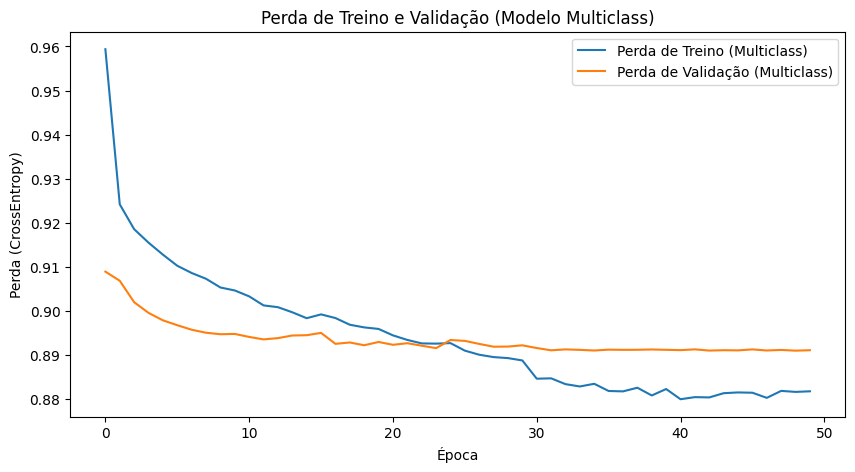

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_loss_history_mc, label='Perda de Treino (Multiclass)')
plt.plot(val_loss_history_mc, label='Perda de Validação (Multiclass)')
plt.xlabel('Época')
plt.ylabel('Perda (CrossEntropy)')
plt.title('Perda de Treino e Validação (Modelo Multiclass)')
plt.legend()
plt.show()

In [51]:
# --- Evaluation for Multiclass Model ---
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

model_mc.eval() # Ensure model is in eval mode
all_predictions_mc = []
all_true_mc = [] # Store true labels [0, 1, 2]

print("\n--- Iniciando Avaliação Multiclass no Conjunto de Teste ---")

with torch.no_grad():
    test_pbar_mc = tqdm(test_loader_mc, desc="Avaliando Teste (Multiclass)", leave=False)
    for batch_x, batch_y in test_pbar_mc:
        test_outputs = model_mc(batch_x) # Get logits
        # Get predicted class index by finding the max logit
        _, predicted_classes = torch.max(test_outputs, 1)

        all_predictions_mc.extend(predicted_classes.numpy())
        all_true_mc.extend(batch_y.numpy())

# Map predictions [0, 1, 2] back to [-1, 0, 1] for original comparison if desired
# all_predictions_original_scale = [p - 1 for p in all_predictions_mc]
# all_true_original_scale = y_test.tolist() # Use original y_test

# Calculate metrics using the [0, 1, 2] scale
test_accuracy_mc = accuracy_score(all_true_mc, all_predictions_mc)
test_confusion_mc = confusion_matrix(all_true_mc, all_predictions_mc)
# Define target names for [0, 1, 2] mapping
target_names_mc = ['Low Worry (0 -> -1)', 'Medium Worry (1 -> 0)', 'High Worry (2 -> 1)']
test_classification_report_mc = classification_report(all_true_mc, all_predictions_mc, target_names=target_names_mc)

# Imprimir resultados
print(f"\n--- Avaliação Final (Modelo Multiclass) ---")
# print(f"Perda Média de Teste: {avg_test_loss_mc:.4f}") # Loss calculation during eval wasn't added, but can be
print(f"Acurácia de Teste: {test_accuracy_mc:.4f}")
print("Matriz de Confusão (Classes 0, 1, 2):\n", test_confusion_mc)
print("Relatório de Classificação (Classes 0, 1, 2):\n", test_classification_report_mc)


--- Iniciando Avaliação Multiclass no Conjunto de Teste ---



--- Avaliação Final (Modelo Multiclass) ---
Acurácia de Teste: 0.5771
Matriz de Confusão (Classes 0, 1, 2):
 [[7209 2857 1580]
 [1703 2583 2307]
 [ 796 2544 6294]]
Relatório de Classificação (Classes 0, 1, 2):
                        precision    recall  f1-score   support

  Low Worry (0 -> -1)       0.74      0.62      0.68     11646
Medium Worry (1 -> 0)       0.32      0.39      0.35      6593
  High Worry (2 -> 1)       0.62      0.65      0.64      9634

             accuracy                           0.58     27873
            macro avg       0.56      0.55      0.55     27873
         weighted avg       0.60      0.58      0.59     27873



In [ ]:
# ... existing code in cell 5b54a62b ...

# Load the best model
print(f"\nCarregando o melhor modelo ordinal salvo de {model} (perda: {best_val_loss_mc:.4f})")
model_mc.load_state_dict(torch.load(model_save_path_mc))

# --- Save the state_dict using pickle as well ---
import pickle
pkl_save_path_mc = 'best_multiclass_nn_model.pkl' # Define the .pkl file path
try:
    with open(pkl_save_path_mc, 'wb') as f:
        pickle.dump(model_mc.state_dict(), f)
    print(f"State_dict também salvo em formato pickle: {pkl_save_path_mc}")
except Exception as e:
    print(f"Erro ao salvar state_dict como pickle: {e}")
# --- End of pickle saving ---


print("\nTreinamento Multiclass concluído.")